In [ ]:

# only run this once if required and margin list has changes from website!!! 
# just run everything else below this cell on regular basis

# import margin from westpac website
import tabula
import pandas as pd
myfile = 'https://www.westpac.com.au/content/dam/public/wbc/documents/pdf/pb/1999030/WOIL_Acceptable_Securities_List.pdf'

df2 = tabula.read_pdf(myfile,pages='all')
frames = [df2[0],df2[1],df2[2],df2[3]]
df2 = pd.concat(frames)
df2.drop(['Unnamed: 0','Unnamed: 1','APIR Code','Fund Name','APIR Code Fund Name'],axis=1) 
split1 = df2[['ASX Code','Security Name','LVR']]
split2 = df2[['ASX Code.1','Security Name.1','LVR.1']]
split2.columns=['ASX Code','Security Name','LVR']
df2 = pd.concat([split1,split2])
df2 = df2.dropna()
df2 = df2.drop_duplicates(subset=['ASX Code'])
#df2.loc[:,'ASX Code']=df2['ASX Code'] + '.AX'


a = pd.read_csv('margin.csv')
df = pd.merge(a,df2,on='ASX Code',how='left')
df = df.drop(['LVR_x','Security Name_x'],axis=1)
df = df.rename(columns={'Security Name_y':'Security Name','LVR_y':'LVR'})
df = df[['ASX Code','Security Name','LVR','Industry','Valuation']]
df = df.dropna(subset=['Security Name'])


# convert string % to numeric %
df['LVR'] = df['LVR'].apply(lambda x:x.strip('%'))
df['LVR'] = pd.to_numeric(df['LVR'])/100


#df = df.style.set_properties(**{'text-align': 'left'})

df.to_csv('margin.csv')

In [389]:
from IPython.display import display
import pandas as pd


#print("Enter Your Date YYYY-MM-DD ")
mydate = '2021-02-19'
mydate = pd.to_datetime(mydate)


In [467]:
import pandas as pd
import datetime
import math
import numpy as np
#import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import date, timedelta
import yfinance as yf

pd.set_option('mode.chained_assignment',None)    # turn off chain error warning since I use loc function properly
pd.options.display.float_format = '{:,.2f}'.format


# myfunction to use MACD to give signal


# 1. look at mac
# 2. look at overall market 

def MAC(MACD,Trigger,MACDiff,Movement,Vol):
    
    # rule 1 looking for buying point (MACDiff trending up - positive)
    
    if MACD >= Trigger:   # logic for MACD > Trigger
        if MACD <= 0:     # below x axis (negative MACD) 
            action = 'Buy Confirm'
        elif MACD > 0:    # above x axis (positive MACD)  
            if MACDiff > 0:
                action = 'Hold'
            else:
                action = 'Time to Sell'
    elif MACD < Trigger:  # logic for MACD < Trigger
        if MACD <=0:      # below x axis (negative MACD)
            if MACDiff > 0:
                action = 'Buy Accumulate'
            elif Movement > 0 and Vol > 0:
                action = 'Market Buying'
            else:
                action = 'Time to Sell'
        elif MACD > 0:    # above x axis (positive MACD)
            if MACDiff > 0:
                action = 'Hold'
            elif Movement < 0 and Vol > 0:
                action = 'Market Selling'
            else:
                action = 'Time to Sell'
    else:
        action='Nothing'
            
    return action


# pick up data from yahoo finance
start = datetime.datetime(2020, 7, 1)
end = datetime.date.today() + datetime.timedelta(days=1)
#end = datetime.datetime(2020,10,14)


# new code to pick up from csv instead with more details
mycsv = 'https://raw.githubusercontent.com/RonnyCh/mydsbook/master/margin.csv'
mycsv = pd.read_csv(mycsv)
mycsv = mycsv[['ASX Code','Security Name','LVR','Industry','Valuation']]
mycsv = mycsv.rename(columns = {'ASX Code':'Code'})
mycsv['Code'] = mycsv['Code'] + '.AX'

# add some indexes and other codes manually here
lastrow = mycsv.shape[0]
addList = ['^AORD','^DJI','^FTSE','CL=F','Z1P.AX']
addName = ['Ordinaries','Dow Jones','Footsie','Petrol','ZIP Payment']

for i, desc in enumerate(addList):
    mycsv.loc[lastrow+i,'ASX Code'] = desc
    mycsv.loc[lastrow+i,'Security Name'] = addName[i]
    mycsv.loc[lastrow+i,'LVR'] = 0
    mycsv.loc[lastrow+i,'Industry'] = 'Index'
    mycsv.loc[lastrow+i,'Valuation'] = 0
#################################################


# convert to string to make it better with dowloanding tracker
mystring = ''
mylist = []
for i in mystock:
    if i in ['^AORD','^DJI','^FTSE','CL=F']:     # indexes no need to add .AX
        mystring = mystring + ' ' + i
        mylist.append(i)
    else:
        mystring = mystring + ' ' + i + '.AX'
        mylist.append(i+'.AX')

# download data 
data = yf.download(mystring, start=start, end=end, group_by="ticker")


# create columns for dataframe and the dataframe itself
mycol = []
mytbl = pd.DataFrame(columns=mycol)


# looping through the list to modify table
for i in mylist:
    #df = web.DataReader(i, 'yahoo', start, end)[['Close','Volume']]    # old code using datareader (not working well)
    #df = yf.download(i, start=start, end=end)[['Close','Volume']]      # old Yfinance code
    
    df = data[i][['Close','Volume']]     # new one using Yfinance
    df['Code'] = i
    
    
    
############### avg 5 and 10 days
    ma_day = [5, 10, 30]
    for ma in ma_day:
        column_name = f"Avg-{ma}days"
        df[column_name] = df['Close'].ewm(span=ma).mean()
    df['P/30Days'] = df['Close']/df['Avg-30days']
    df['Mov-3Days'] = df['Close'].diff(1)
    df['MACD'] = df.iloc[:,3] - df.iloc[:,4]    # column 5 - columns 4 (Long - Short Avg)    
    df['Trigger'] = df.MACD.rolling(window=3).mean()
    df['MACD_Diff'] = df['MACD'].diff(1)
    df['Vol_Diff'] = df['Volume'].diff(1)
    df['Advice'] = df.apply(lambda x:MAC(x['MACD'],x['Trigger'],x['MACD_Diff'],x['Mov-3Days'],x['Vol_Diff']),axis=1)
    mytbl = mytbl.append(df)
################    


# Tidy Up the table by dropping null values for close
mytbl = mytbl.dropna(subset=['Close'])
mytbl = mytbl.reset_index()
mytbl = mytbl.rename(columns={'index':'Date'})


# link back mytbl to csv to get more information such as LVR, Industry Etc.
mytbl = pd.merge(mytbl,mycsv,on='Code',how='left')
mytbl = mytbl[['Date', 'Close', 'Volume', 'Code', 'Security Name','Industry','Advice',  'LVR',  'Valuation'
               , 'MACD', 'Trigger', 'MACD_Diff','P/30Days','Vol_Diff','Avg-5days', 'Avg-10days', 'Avg-30days', 'Mov-3Days'
               ]]


# create multiple dataframes to make it easy to drill down . E.g just type AGL, WPL etc
for x,y,z,w in zip(mystock,mylist,mycsv['Security Name'],mycsv['LVR']):
    #df = web.DataReader(i, 'yahoo', start, end)[['Close','Volume']]    # old code using datareader (not working well)
    #df = yf.download(i, start=start, end=end)[['Close','Volume']]      # old Yfinance code
    
    vars()[x] = data[y][['Close','Volume']]     # new one using Yfinance
    
    df['Code'] = i
    
    
############### avg 5 and 10 days
    ma_day = [5, 10, 30]
    for ma in ma_day:
        column_name = f"Avg-{ma}days"
        vars()[x][column_name] = vars()[x]['Close'].ewm(span=ma).mean()
    vars()[x]['P/30Days'] = df['Close']/df['Avg-30days']
    vars()[x]['Mov-3Days'] = vars()[x]['Close'].diff(1)
    vars()[x]['MACD'] = vars()[x].iloc[:,2] - vars()[x].iloc[:,3]    # column 5 - columns 4 (Long - Short Avg)    
    vars()[x]['Trigger'] = vars()[x].MACD.rolling(window=3).mean()
    vars()[x]['MACD_Diff'] = vars()[x]['MACD'].diff(1)
    vars()[x]['Vol_Diff'] = vars()[x]['Volume'].diff(1)
    vars()[x]['Advice'] = vars()[x].apply(lambda x:MAC(x['MACD'],x['Trigger'],x['MACD_Diff'],x['Mov-3Days'],x['Vol_Diff']),axis=1)
    vars()[x]['Company Name'] = z
    vars()[x]['LVR'] = w
################    

    
    

[*********************100%***********************]  394 of 394 completed

5 Failed downloads:
- ^HIS.AX: No data found, symbol may be delisted
- ^AXJO.AX: No data found, symbol may be delisted
- Z1P.AX.AX: No data found, symbol may be delisted
- ^N225.AX: No data found, symbol may be delisted
- ^IXIC.AX: No data found, symbol may be delisted


In [499]:
def total(type,unit,price,brokerage):
    if type == 'Buy':
        result = ((unit * price) + brokerage) * -1
    else:
        result = (unit * price) - brokerage
    return result


myval = [
    # Bought Date, Sold Date, Code, Type, Unit, Price, Margin
  
      # Bought Date, Sold Date, Code, Type, Unit, Price, Margin
    ['2020-10-15','AGL.AX','Buy','Long Term','Open',4447,13.55,19.95],
    ['2020-12-15','AGL.AX','Buy','Short Term','Open',775,12.885,19.95],
    ['2020-8-27','IAG.AX','Buy','Short Term','Open',3030,5.08,19.95],
    ['2020-12-04','CSL.AX','Buy','Long Term','Open',33,294.19,19.95], 
    ['2020-12-11','CSL.AX','Buy','Long Term','Open',68,292.025,19.95], 
    ['2020-12-21','CSL.AX','Buy','Long Term','Open',34,287.511,19.95], 
    ['2020-8-26','WPL.AX','Buy','Long Term','Open',1275,19.98,19.95],
    ['2020-12-2','WPL.AX','Buy','Long Term','Open',224,22.24,19.95], 
    ['2021-1-4','LNK.AX','Buy','Long Term','Open',1236,4.78,19.95],
    ['2020-8-27','IAG.AX','Buy','Short Term','Open',3030,5.08,19.95],
    
    
    ['2020-12-21','TWE.AX','Buy','Short Term','Closed',607,9.38,19.95],
    ['2020-11-25','WPL.AX','Buy','Short Term','Closed',427,23.36,19.95],
    ['2021-1-12' ,'CSL.AX','Buy','Short Term','Closed',54,274.11,19.95], 
    ['2020-8-27','IAG.AX','Buy','Short Term','Closed',3030,5.08,19.95],
    ['2021-02-19','TWE.AX','Sell','Short Term','Closed',607,9.79,19.95],
    ['2021-02-19','WPL.AX','Sell','Short Term','Closed',427,23.99,19.95],
    ['2021-02-19' ,'CSL.AX','Sell','Short Term','Closed',54,276,19.95], 
    ['2021-02-19','IAG.AX','Sell','Short Term','Closed',3030,4.952,19.95],
     ]


myprofit = DataFrame (myval,columns=['PurchaseDate','Code','Type','Position','Status','Unit','Price','Brokerage'])
myprofit['Total']=myprofit.apply(lambda x:total(x['Type'],x['Unit'],x['Price'],x['Brokerage']),axis=1)
mylist = myprofit['Code'].drop_duplicates().tolist()
myprofit['PurchaseDate'] = pd.to_datetime(myprofit['PurchaseDate'])


mydf = mytbl[(mytbl['Code'].isin(mylist)) & (mytbl['Date']==mydate)]


finalprofit = pd.merge(myprofit,mydf,on='Code',how='left')

finalprofit = finalprofit[['PurchaseDate', 'Code', 'Position', 'Type','Status','Unit', 'Price', 'Brokerage','Total',
       'Close',  'Avg-5days', 'Avg-10days', 
       'MACD', 'Trigger', 'MACD_Diff', 'Vol_Diff', 'Advice','LVR']]


### add more calculation
finalprofit['Capital'] = (finalprofit['Unit'] * finalprofit['Price']) 
finalprofit['Margin'] = (finalprofit['Unit'] * finalprofit['Price']) * (1-finalprofit['LVR'])
finalprofit['Profit'] = (finalprofit['Close'] - finalprofit['Price']) * finalprofit['Unit']
finalprofit['%'] = (finalprofit['Close'] - finalprofit['Price']) * finalprofit['Unit'] / finalprofit['Capital']
finalprofit['Days'] = mydate - finalprofit['PurchaseDate']
finalprofit['Days'] = finalprofit['Days'].dt.days.astype('int16')
finalprofit['Interest'] = (finalprofit['Capital'] - finalprofit['Margin']) * 3.75/100 / 265 * finalprofit['Days']

finalprofit['NetProfit'] = finalprofit['Profit'] - finalprofit['Interest']
finalprofit['Net%'] = finalprofit['NetProfit']/finalprofit['Capital']
########################

colProfit = ['PurchaseDate', 'Code', 'Position', 'Type','Status','Unit', 'Price',
       'Brokerage','Total','Close', 'Advice', 'Capital', 'Margin', 'Profit', '%', 'Days',
       'Interest', 'NetProfit', 'Net%']

finalprofit = finalprofit[colProfit].sort_values(['Status','Code'],ascending=False)

opn = finalprofit[finalprofit['Status']=='Open']
closed = finalprofit[finalprofit['Status']=='Closed']

a = closed.groupby('Code').sum()['Total']
b = closed[closed['Type']=='Buy'].groupby('Code').sum()['Profit']
compare = pd.merge(a,b,on='Code')
compare['Var'] = compare['Total'] - compare['Profit']
compare.columns=(['Closed','Open','Variance'])

display(compare)

display(opn)

,Closed,Open,Variance
Code,,,
CSL.AX,62.16,17.28,44.88
IAG.AX,-427.74,-393.90,-33.84
TWE.AX,208.97,"1,092.60",-883.63
WPL.AX,229.11,273.28,-44.17


,PurchaseDate,Code,Position,Type,Status,Unit,Price,Brokerage,Total,Close,Advice,Capital,Margin,Profit,%,Days,Interest,NetProfit,Net%
6,2020-08-26,WPL.AX,Long Term,Buy,Open,1275,19.98,19.95,"-25,494.45",24.00,Time to Sell,"25,474.50","6,368.62","5,125.50",0.20,177,478.55,"4,646.95",0.18
7,2020-12-02,WPL.AX,Long Term,Buy,Open,224,22.24,19.95,"-5,001.71",24.00,Time to Sell,"4,981.76","1,245.44",394.24,0.08,79,41.77,352.47,0.07
8,2021-01-04,LNK.AX,Long Term,Buy,Open,1236,4.78,19.95,"-5,928.03",4.80,Time to Sell,"5,908.08","2,363.23",24.72,0.00,46,23.07,1.65,0.00
2,2020-08-27,IAG.AX,Short Term,Buy,Open,3030,5.08,19.95,"-15,412.35",4.95,Time to Sell,"15,392.40","3,848.10",-393.90,-0.03,176,287.52,-681.42,-0.04
9,2020-08-27,IAG.AX,Short Term,Buy,Open,3030,5.08,19.95,"-15,412.35",4.95,Time to Sell,"15,392.40","3,848.10",-393.90,-0.03,176,287.52,-681.42,-0.04
3,2020-12-04,CSL.AX,Long Term,Buy,Open,33,294.19,19.95,"-9,728.22",274.43,Market Selling,"9,708.27","2,427.07",-652.08,-0.07,77,79.34,-731.42,-0.08
4,2020-12-11,CSL.AX,Long Term,Buy,Open,68,292.02,19.95,"-19,877.65",274.43,Market Selling,"19,857.70","4,964.42","-1,196.46",-0.06,70,147.53,"-1,343.99",-0.07
5,2020-12-21,CSL.AX,Long Term,Buy,Open,34,287.51,19.95,"-9,795.32",274.43,Market Selling,"9,775.37","2,443.84",-444.75,-0.05,60,62.25,-507.00,-0.05
0,2020-10-15,AGL.AX,Long Term,Buy,Open,4447,13.55,19.95,"-60,276.80",10.10,Time to Sell,"60,256.85","15,064.21","-15,342.15",-0.25,127,812.19,"-16,154.34",-0.27
1,2020-12-15,AGL.AX,Short Term,Buy,Open,775,12.88,19.95,"-10,005.83",10.10,Time to Sell,"9,985.88","2,496.47","-2,158.37",-0.22,66,69.95,"-2,228.32",-0.22


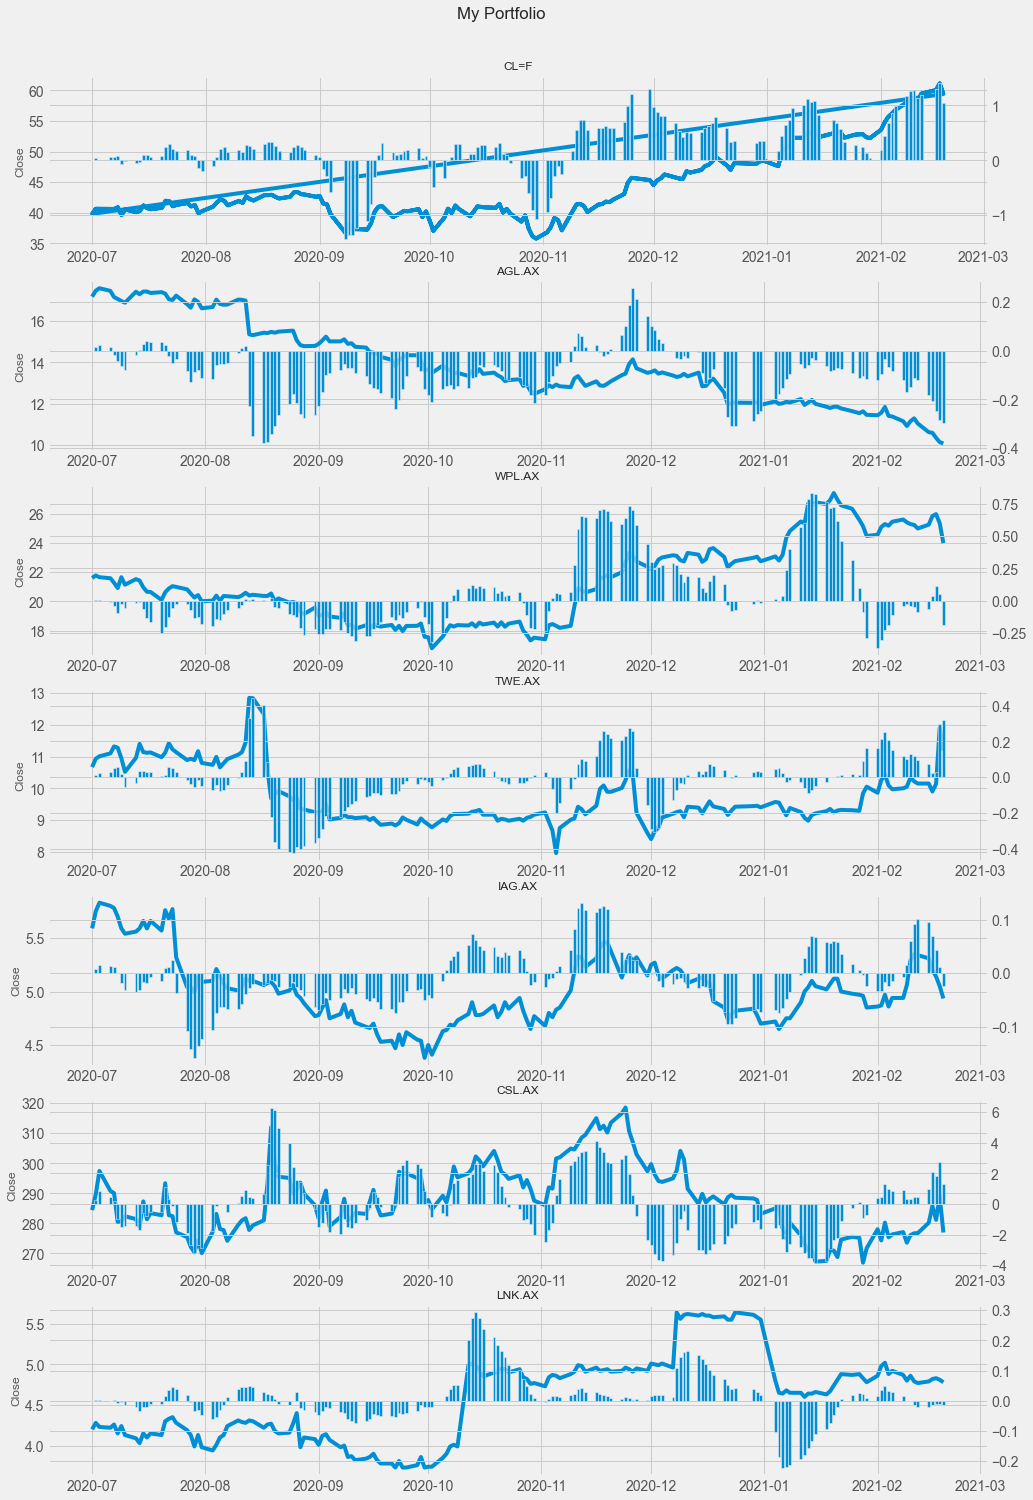

In [395]:
# Let's see a historical view of the closing price
import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use("seaborn-bright")

mylist = ['CL=F','AGL.AX','WPL.AX','TWE.AX','IAG.AX','CSL.AX','LNK.AX']

fig, ax = plt.subplots(7,figsize=(15,24))

plt.suptitle('My Portfolio',y=0.92)   # y = 1 is at the top of the figure so reduce it to make it lower
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(mylist):
    
    #code['Close'].plot()
    tmpStock = mytbl[mytbl['Code']==company]
    ax[i].plot(tmpStock['Date'],tmpStock['Close'])
    z = ax[i].twinx()
    z.bar(tmpStock['Date'],tmpStock['MACD'])
    #plt.plot(tmpStock['Date'],tmpStock['Avg-10days'])
    #ax[i].set_xticklabels(fontsize=7)
    #ax[i].set_yticks(fontsize=9)
    ax[i].set_ylabel('Close',fontsize=12)
    ax[i].set_xlabel(None)
    ax[i].set_title(company,fontsize=12,y=1)

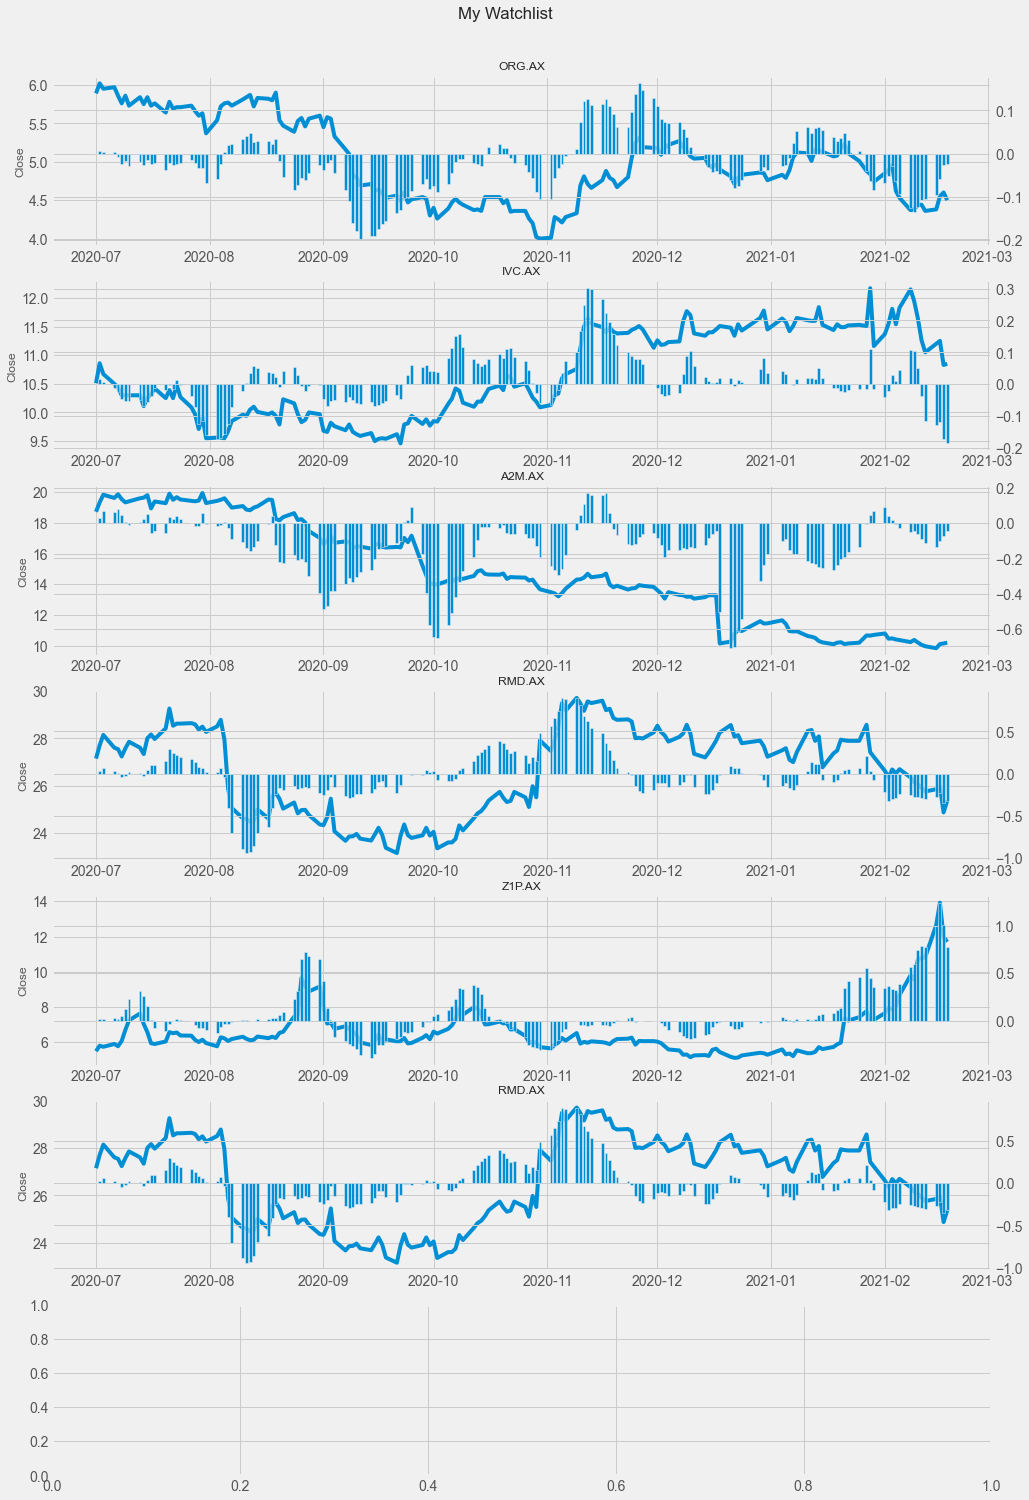

In [387]:
# Let's see a historical view of the closing price
import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use("seaborn-bright")

mylist = ['ORG.AX','IVC.AX','A2M.AX','RMD.AX','Z1P.AX','RMD.AX']

fig, ax = plt.subplots(7,figsize=(15,24))

plt.suptitle('My Watchlist',y=0.92)   # y = 1 is at the top of the figure so reduce it to make it lower
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(mylist):
    
    #code['Close'].plot()
    tmpStock = mytbl[mytbl['Code']==company]
    ax[i].plot(tmpStock['Date'],tmpStock['Close'])
    z = ax[i].twinx()
    z.bar(tmpStock['Date'],tmpStock['MACD'])
    #plt.plot(tmpStock['Date'],tmpStock['Avg-10days'])
    #ax[i].set_xticklabels(fontsize=7)
    #ax[i].set_yticks(fontsize=9)
    ax[i].set_ylabel('Close',fontsize=12)
    ax[i].set_xlabel(None)
    ax[i].set_title(company,fontsize=12,y=1)

In [ ]:
# Let's see a historical view of the closing price
import seaborn as sns
#sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use("seaborn-bright")

mylist = ['BXB.AX','CPU.AX','IVC.AX','DXS.AX','PPT.AX','PDL.AX']

fig, ax = plt.subplots(7,figsize=(15,24))

plt.suptitle('Morningstar with Moats',y=0.92)   # y = 1 is at the top of the figure so reduce it to make it lower
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(mylist):
    
    #code['Close'].plot()
    tmpStock = mytbl[mytbl['Code']==company]
    ax[i].plot(tmpStock['Date'],tmpStock['Close'])
    z = ax[i].twinx()
    z.bar(tmpStock['Date'],tmpStock['MACD'])
    #plt.plot(tmpStock['Date'],tmpStock['Avg-10days'])
    #ax[i].set_xticklabels(fontsize=7)
    #ax[i].set_yticks(fontsize=9)
    ax[i].set_ylabel('Close',fontsize=12)
    ax[i].set_xlabel(None)
    ax[i].set_title(company,fontsize=12,y=1)

In [381]:
x = mytbl[(mytbl['Date'] > '2021-02-14') & (mytbl['Advice'].str.contains('Buy'))]
x.sort_values('P/30Days').head(50)

,Date,Close,Volume,Code,Security Name,Industry,Advice,LVR,Valuation,MACD,Trigger,MACD_Diff,P/30Days,Vol_Diff,Avg-5days,Avg-10days,Avg-30days,Mov-3Days
31454,2021-02-16,5.40,"186,490.00",MEZ.AX,Meridian Energy Limited,Utilities,Market Buying,0.60,0.00,-0.32,-0.30,-0.00,0.83,"44,922.00",5.67,5.99,6.52,0.11
58838,2021-02-17,0.87,"643,137.00",VTG.AX,Vita Group Limited,Retailing,Buy Confirm,0.40,0.00,-0.05,-0.05,0.00,0.86,"-719,359.00",0.90,0.95,1.01,0.00
13526,2021-02-16,21.09,"823,688.00",CIM.AX,Cimic Group Limited,Capital Goods,Buy Confirm,0.65,36.00,-1.08,-1.14,0.11,0.87,"74,519.00",21.57,22.65,24.19,0.29
58839,2021-02-18,0.88,"814,633.00",VTG.AX,Vita Group Limited,Retailing,Buy Confirm,0.40,0.00,-0.04,-0.05,0.00,0.87,"171,496.00",0.89,0.94,1.00,0.00
31456,2021-02-18,5.60,"82,361.00",MEZ.AX,Meridian Energy Limited,Utilities,Buy Confirm,0.60,0.00,-0.22,-0.26,0.03,0.87,"-2,565.00",5.67,5.89,6.41,-0.17
13527,2021-02-17,20.95,"1,047,493.00",CIM.AX,Cimic Group Limited,Capital Goods,Buy Confirm,0.65,36.00,-0.97,-1.08,0.10,0.87,"223,805.00",21.36,22.34,23.98,-0.14
31455,2021-02-17,5.77,"84,926.00",MEZ.AX,Meridian Energy Limited,Utilities,Buy Confirm,0.60,0.00,-0.25,-0.30,0.08,0.89,"-101,564.00",5.70,5.95,6.47,0.37
13528,2021-02-18,21.25,"920,278.00",CIM.AX,Cimic Group Limited,Capital Goods,Buy Confirm,0.65,36.00,-0.81,-0.95,0.16,0.89,"-127,215.00",21.33,22.14,23.80,0.30
60140,2021-02-15,2.09,"1,921,556.00",WGX.AX,Westgold Resources Limited,Materials,Buy Accumulate,0.45,0.00,-0.06,-0.06,0.01,0.90,"-2,477,457.00",2.12,2.19,2.33,0.09
60141,2021-02-16,2.08,"1,511,082.00",WGX.AX,Westgold Resources Limited,Materials,Buy Confirm,0.45,0.00,-0.06,-0.06,0.01,0.90,"-410,474.00",2.11,2.17,2.32,-0.01


In [331]:
IVC[-20:]

,Close,Volume,Avg-5days,Avg-10days,Avg-30days,P/30Days,Mov-3Days,MACD,Trigger,MACD_Diff,Vol_Diff,Advice,Company Name,LVR
Date,,,,,,,,,,,,,,
2021-01-22,11.52,"194,536.00",11.52,11.54,11.49,nan,0.03,-0.02,-0.02,0.00,"-80,327.00",Buy Confirm,InvoCare Limited,0.65
2021-01-25,11.53,"167,914.00",11.52,11.54,11.49,nan,0.01,-0.01,-0.02,0.01,"-26,622.00",Buy Confirm,InvoCare Limited,0.65
2021-01-26,nan,nan,11.52,11.54,11.49,nan,nan,-0.01,-0.02,0.00,nan,Buy Confirm,InvoCare Limited,0.65
2021-01-27,11.51,"431,907.00",11.52,11.53,11.49,nan,nan,-0.01,-0.01,0.00,nan,Buy Confirm,InvoCare Limited,0.65
2021-01-28,12.17,"1,874,192.00",11.77,11.66,11.54,nan,0.66,0.11,0.03,0.12,"1,442,285.00",Hold,InvoCare Limited,0.65
2021-01-29,11.16,"851,235.00",11.55,11.56,11.51,nan,-1.01,-0.02,0.03,-0.12,"-1,022,957.00",Time to Sell,InvoCare Limited,0.65
2021-02-01,11.37,"727,301.00",11.48,11.52,11.50,nan,0.21,-0.04,0.02,-0.02,"-123,934.00",Time to Sell,InvoCare Limited,0.65
2021-02-02,11.55,"283,664.00",11.51,11.53,11.51,nan,0.18,-0.02,-0.03,0.02,"-443,637.00",Buy Confirm,InvoCare Limited,0.65
2021-02-03,11.81,"358,390.00",11.61,11.58,11.53,nan,0.26,0.03,-0.01,0.05,"74,726.00",Hold,InvoCare Limited,0.65


# Check Transactions Here

In [402]:
mygain = pd.read_csv('RealisedGain.csv')
mygain = mygain.drop(['Net Proceeds','Dividend Per Share','Dividend Total'],axis=1)

def total(type,unit,price,brokerage):
    if type == 'B':
        result = ((unit * price) + brokerage) * -1
    else:
        result = (-unit * price) - brokerage
    return result


mytran = [['2021-02-17','S','TWE',-607,9.79,19.95],
          ['2021-02-17','B','TWE',607,9.38,19.95],
          ['2021-01-12','S','ALL',-313,31.27,19.95],
          ['2020-12-04','B','ALL',313,31.87,19.95],
          ['2021-01-5','S','ORG',-2096,4.74,19.95],
          ['2020-12-23','B','ORG',2096,4.76,19.95],
          
          ['2021-02-19','S','CSL',-54,276,19.95],
          ['2020-12-01','B','CSL',54,274.11,19.95],
          
          ['2021-02-19','S','IAG',-3030,4.952,19.95],
          ['2020-8-27','B','IAG',3030,5.08,19.95],
          
          ['2021-02-19','S','WPL',-427,23.99,19.95],
          ['2020-8-27','B','WPL',427,23.36,19.95],
         ]

df_tran = DataFrame (mytran,columns=['Trade Date','Order Type','Code','Units','Average Price','Brokerage'])
mygain = mygain.append(df_tran)



mygain['Total']=mygain.apply(lambda x:total(x['Order Type'],x['Units'],x['Average Price'],x['Brokerage']),axis=1)


unit = mygain['Units'].sum()
profit = mygain['Total'].sum()

print (unit, round(profit,0))

0 -16843.0


In [403]:
mygain.tail(10)

,Trade Date,Order Type,Code,Units,Average Price,Brokerage,Status,Grouped,Month,Total
2,2021-01-12,S,ALL,-313,31.27,19.95,NaN,NaN,NaN,"9,767.56"
3,2020-12-04,B,ALL,313,31.87,19.95,NaN,NaN,NaN,"-9,995.26"
4,2021-01-5,S,ORG,-2096,4.74,19.95,NaN,NaN,NaN,"9,915.09"
5,2020-12-23,B,ORG,2096,4.76,19.95,NaN,NaN,NaN,"-9,996.91"
6,2021-02-19,S,CSL,-54,276.00,19.95,NaN,NaN,NaN,"14,884.05"
7,2020-12-01,B,CSL,54,274.11,19.95,NaN,NaN,NaN,"-14,821.89"
8,2021-02-19,S,IAG,-3030,4.95,19.95,NaN,NaN,NaN,"14,984.61"
9,2020-8-27,B,IAG,3030,5.08,19.95,NaN,NaN,NaN,"-15,412.35"
10,2021-02-19,S,WPL,-427,23.99,19.95,NaN,NaN,NaN,"10,223.78"
11,2020-8-27,B,WPL,427,23.36,19.95,NaN,NaN,NaN,"-9,994.67"


In [400]:
mygain.groupby(['Code']).sum()[['Units','Total']].sort_values('Code')

,Units,Total
Code,,
A200,0,"2,295.64"
AGL,0,730.29
AIG,0,-463.26
ALL,0,-227.70
ANN,0,-117.55
ANZ,0,162.58
AVH,0,-405.72
BAP,0,"-2,535.41"
BBOZ,0,"-1,008.90"


In [366]:
mygain[mygain['Code']=='A200']

,Trade Date,Order Type,Code,Units,Average Price,Brokerage,Status,Grouped,Month,Total
0,18/03/2020,B,A200,175,85.84,19.95,Confirmed,1/04/2020,2020-04,"-15,041.95"
1,27/03/2020,B,A200,170,88.10,19.95,Confirmed,1/04/2020,2020-04,"-14,996.95"
2,30/03/2020,B,A200,178,83.62,19.95,Confirmed,1/04/2020,2020-04,"-14,904.31"
3,1/04/2020,S,A200,-262,87.90,25.33,Confirmed,1/04/2020,2020-04,"23,004.47"
4,1/04/2020,S,A200,-261,86.72,24.89,Confirmed,1/04/2020,2020-04,"22,609.03"
5,3/04/2020,B,A200,234,85.42,21.99,Confirmed,22/05/2020,2020-05,"-20,010.27"
6,7/04/2020,B,A200,111,90.20,19.95,Confirmed,22/05/2020,2020-05,"-10,032.15"
7,7/04/2020,S,A200,-111,88.40,19.95,Confirmed,22/05/2020,2020-05,"9,792.45"
8,16/04/2020,S,A200,-140,90.11,19.95,Confirmed,22/05/2020,2020-05,"12,595.03"
9,21/04/2020,B,A200,140,87.94,19.95,Confirmed,22/05/2020,2020-05,"-12,331.55"
